In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
from tqdm import tqdm

import pandas as pd
import networkx as nx
import numpy as np

from src.data.graph import load_graph_data

# 1. Data loading

In [2]:
graph_data = load_graph_data()
print("\nKeys:\n\t{}".format("    ".join(graph_data.keys())))

loading raw data from tsv files...
formatting articles...
formatting categories...
formatting links...
formatting paths...
formatting distance matrix...
building graph...

Keys:
	paths_finished    paths_unfinished    articles    categories    links    shortest-path-distance-matrix    graph


In [3]:
graph_data["articles"].head(1)

,name
0,Áedán_mac_Gabráin


In [4]:
graph_data["links"].head(1)

,source_name,target_name
0,Áedán_mac_Gabráin,Bede


In [5]:
graph_data["categories"].head(1)

,category,article_name
0,subject.History.British_History.British_Histor...,Áedán_mac_Gabráin


In [6]:
graph_data["paths_finished"].head(1)

,hashedIpAddress,timestamp,durationInSec,path,rating,source,datetime,target
0,6a3701d319fc3754,1297740409,166,"[14th_century, 15th_century, 16th_century, Pac...",NULL,14th_century,2011-02-15 04:26:49,African_slave_trade


In [7]:
graph_data["paths_unfinished"].head(1)

,hashedIpAddress,timestamp,durationInSec,path,target,type,source,datetime
0,2426091a53125110,1297054935,1804,[Obi-Wan_Kenobi],Microsoft,timeout,Obi-Wan_Kenobi,2011-02-07 06:02:15


In [8]:
graph_data["shortest-path-distance-matrix"].shape

(4604, 4604)

In [9]:
# `networkx` directed graph, see documentation at https://networkx.org
graph_data["graph"]

In [10]:
# sanity check the graph
# note: if there is no output it means the graph is consistent with the given shortest path distance matrix

distance_matrix = graph_data["shortest-path-distance-matrix"]
valid_indices = [(i, j) for i in range(len(distance_matrix)) for j in range(len(distance_matrix))]

for source_index, target_index in tqdm(valid_indices):
    best_distance = distance_matrix[(source_index, target_index)]
    if best_distance > 1:
        continue
    
    source = graph_data["articles"]["name"].iloc[source_index]
    target = graph_data["articles"]["name"].iloc[target_index]

    found_shortest_length = float("inf")
    try:
        shortest_path = nx.shortest_path(graph_data["graph"], source=source, target=target)
        found_shortest_length = len(shortest_path) - 1
        
        if best_distance == np.nan:
            print(source, "->", target, "should not exist")
            
        if found_shortest_length > best_distance:
            print(source, "->", target, "should exist")
    except:
        if best_distance < found_shortest_length:
            # If an article has no links, the nx graph ignores it, but the distance matrix registers a distance of 0
            if best_distance > 0:
                print(source, "->", target, "should exist")


100%|██████████| 21196816/21196816 [01:35<00:00, 222144.71it/s]


# 2. Data Exploration

## 2.1. Exploring out degrees (number of unique links per article)

In [11]:
degrees = [deg for _, deg in graph_data["graph"].degree()]

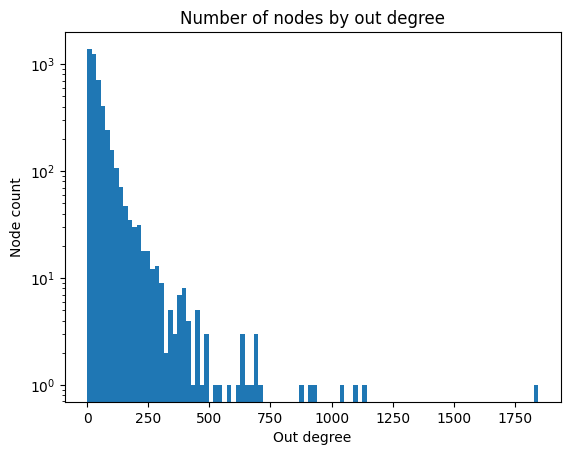

In [12]:
fig, ax = plt.subplots()
ax.hist(degrees, bins=100, log=True)
ax.set_ylabel("Node count")
ax.set_xlabel("Out degree")
ax.set_title("Number of nodes by out degree");

## 2.2. Exploring the number of games played for each source-target pair

In [13]:
game_counts_by_source_target_pair = graph_data['paths_finished'].groupby(["source", "target"]).agg(game_count=("path", "size")).reset_index()
game_counts_by_source_target_pair.sort_values(by='game_count', inplace=True, ascending=False)

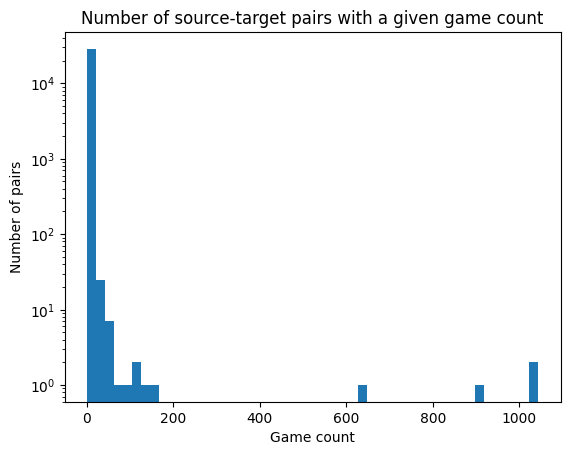

In [14]:
fig, ax = plt.subplots()
ax.hist(game_counts_by_source_target_pair['game_count'].values, bins=50, log=True)
ax.set_title("Number of source-target pairs with a given game count")
ax.set_ylabel("Number of pairs")
ax.set_xlabel("Game count");

In [15]:
game_counts_by_source_target_pair.head(10)

,source,target,game_count
2318,Asteroid,Viking,1043
4427,Brain,Telephone,1040
25700,Theatre,Zebra,905
21255,Pyramid,Bean,642
3206,Batman,Wood,148
3825,Bird,Great_white_shark,138
3201,Batman,The_Holocaust,119
3822,Bird,Adolf_Hitler,107
3498,Beer,Sun,99
3174,Batman,Banana,69


## 2.3. Exploring game difficulty